In [1]:
import Pkg;

# basic packages
using LinearAlgebra, Random, Distributions, Test, Markdown

# packages for nice output
Pkg.add("Latexify"); Pkg.add("LaTeXStrings"); Pkg.add("Formatting");Pkg.add("PrettyTables")
using Latexify, LaTeXStrings, Formatting, PrettyTables

# packages to plot networks
Pkg.add("LightGraphs"); Pkg.add("SimpleWeightedGraphs"); Pkg.add("Gadfly"); Pkg.add("GraphRecipes")
using Plots, LightGraphs, SimpleWeightedGraphs, GraphRecipes

# packages for general plots
Pkg.add("Gadfly"), Pkg.add("Cairo")
using Gadfly, Cairo

# packages for optimization
using NLsolve

   Updating registry at `~/.julia/registries/General`


   Updating git-repo `https://github.com/JuliaRegistries/General.git`


  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`


In [2]:
# enable equation numbering in MathJax

# macro to use javascript inside notebook
macro javascript_str(s) display("text/javascript", s); end;

#=
javascript"""
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});
"""
=#

#=
javascript"""
MathJax.Hub.Register.StartupHook("TeX AMSmath Ready", function () {
  var AMS = MathJax.Extension['TeX/AMSmath'];
  MathJax.InputJax.TeX.postfilterHooks.Add(function (data) {
    var jax = data.script.MathJax;
    jax.startNumber = AMS.startNumber;
    jax.eqLabels = AMS.eqlabels;
    jax.eqIDs = AMS.eqIDs;
  });
  MathJax.InputJax.TeX.prefilterHooks.Add(function (data) {
    var jax = data.script.MathJax;
    if (jax.startNumber != undefined) {
      AMS.startNumber = jax.startNumber;
      Object.keys(jax.eqLabels).forEach(function (x) {delete AMS.labels[x]});
      Object.keys(jax.eqIDs).forEach(function (x) {delete AMS.IDs[x]});
    }
  }, 1);
});

"""
=#

#=
javascript"""
MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);
"""
=#


@javascript_str (macro with 1 method)

Overview
--------

The network model we use is exactly as in [Glasserman and Young (2015)](https://www.sciencedirect.com/science/article/pii/S0378426614000600). The nodes of the network
are all US domestic financial institutions. The connections between
nodes are defined by institutions borrowing from and lending to one
another. There is a link from node $i$ to node $j$ if $i$ has any
net payment obligations towards node $j$. In addition to lending to one
another, nodes can borrow and lend to the rest of the domestic and
global economy. These assets and liabilities are termed as *outside* the
financial system. In our application, the *outside* sector is comprised
of domestic and foreign non-financial institutions, governments, and
households, as well as foreign financial institutions.

<a href="#Fig1">Figure 1</a> shows an example of a simple network, taken from [Glasserman and Young (2015)](https://www.sciencedirect.com/science/article/pii/S0378426614000600). The four arrows
originating in the central node and pointing to the four peripheral
nodes show that the central node owes $10$ to each of the peripheral
nodes. The four peripheral nodes have no borrowing or lending among
themselves. For this network, we say that the central node has *inside
liabilities* of $40$, while each of the peripheral nodes has *inside
assets* of $10$. In practice, we find that inside assets and liabilities
for US financial institutions are primarily composed of deposits, loans
and securities lending transactions.

<figure>
    <img src='../../paper/fig1_networkExample.png' alt='Example of a network' id="Fig1" />
    <figcaption>Figure 1: A simple network</figcaption>
</figure>

In addition to its claims inside the network, the central node has lent
$150$ and has borrowed $100$ from the outside sector, depicted by the
doted lines with arrows going into and out of the central node. We
refer to positive claims with respect to the outside sector as *outside
assets* and to negative claims as *outside liabilities*. Outside assets
typically consist of securities, loans to firms and households
(including mortgages), and public debt. Outside liabilities mostly
involve deposits and lines of credit.

The difference between all assets and all liabilities gives each node’s
net worth. The central node has a net worth of $10$, shown inside the
circle that represents the node. Each of the peripheral nodes has
outside assets of $50$, outside liabilities of $55$ and an inside asset
of $10$ with respect to the central node, for a net worth of $5$.

We will use the following notation for the objects of the network:

$$\begin{aligned}
\bar{p}_{i} &:\text{total liabilities for node }i, \\
f_{i} &:\text{inside liabilities for node }i,\\
b_{i} &:\text{outside liabilities for node }i, \\
a_{i} &:\text{total assets for node }i, \\
d_{i} &:\text{inside assets for node }i, \\
c_{i} &:\text{outside assets for node }i, \\
w_{i} &:\text{net worth for node }i.
\end{aligned}$$

All of the above variables are node-specific, that is, are characteristics of node $i$ when the node is considered in isolation, requiring knowledge of neither how $i$ is connected to other nodes nor of characteristics of other nodes.

We denote the number of nodes of the network by $N$. To keep track of the connections among nodes, we define the $N \times N$ *relative liabilities matrix* $A$ by

$$a_{ij}=\left\{ 
\begin{array}{ccc}
\bar{p}_{ij}/\bar{p}_{i} & , & \text{if }\bar{p}_{i}>0 \\ 
0 & , & \text{if }\bar{p}_{i}=0
\end{array}%
\right.$$

where $\bar{p}_{ij}$ represents the net payments due from $i$ to $j$. Because $a_{ij}$ represents *net* payments, we have that

$$\begin{aligned}
a_{ii} &=0\text{,} &\text{ for }i=1,..,N \\
a_{ij}a_{ji} &=0 \text{,} &\text{ for }i=1,..,N\text{ and }j<i.
\end{aligned}$$

In addition, because payments to $i$ from other nodes $j$ add up to inside assets $d$, we have 

$$\begin{aligned}
\sum_{j=1}^{n}a_{ji}\bar{p}_{j} &=d_{j}\text{,} &\text{ for }i=1,..,N.
\end{aligned}$$

And because payments from $i$ to other nodes add up to inside liabilities $f$, we have

$$\begin{aligned}
\bar{p}_{i}\sum_{j=1}^{n}a_{ij} &=f_{i}\text{,} &\text{ for }i=1,..,N. \\
\end{aligned}$$

Last, by definition, the variables satisfy the following bounds

$$\begin{aligned}
0 &\leq c_{i} \leq assets_{i} & \text{,} &\text{ for }i=1,..,N \\
0 &\leq b_{i} \leq \bar{p}_{i} & \text{,} &\text{ for }i=1,..,N \\
0 &\leq a_{ij} \leq 1 & \text{,} & \text{ for }i,j=1,..,N.
\end{aligned}$$

Now we create and plot the network of <a href="#Fig1">Figure 1</a> using Julia. First, we define the network.

In [3]:
p_bar = (55.0, 55.0, 140.0, 55.0, 55.0); # total liabilities
b = (55.0, 55.0, 100.0, 55.0, 55); # outside liabilities
c = (50.0, 50.0, 150.0, 50.0, 50.0); # outside assets
w = (5.0, 5.0, 10.0, 5.0, 5.0); # net worth
A = [0 0 0 0 0; 0 0 0 0 0; 10.0/p_bar[3] 10.0/p_bar[3] 0 10.0/p_bar[3] 10.0/p_bar[3]; 0 0 0 0 0; 0 0 0 0 0]; # matrix of relative liabilities
a = w .+ p_bar; # total assets
d =  a .- c; # inside assets
f = p_bar .- b; # inside liabilities
N = length(c); # number of nodes

Now we plot the financial network (without outside assets and liabilities).

┌ Warning: `a::StaticArray - b::Number` is deprecated, use `a .- b` instead.
│   caller = _broadcast_getindex_evalf at broadcast.jl:631 [inlined]
└ @ Core ./broadcast.jl:631


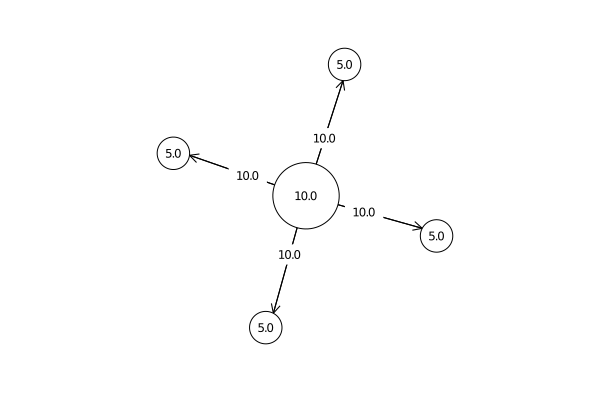

In [4]:
Aplot = deepcopy(A);
Aplot[Aplot.<1e-3] .= 0; # do not show very small edges

graphplot(LightGraphs.DiGraph(Aplot),
          nodeshape = :circle,
          markersize = 0.1,
          node_weights = w,
          markercolor = :white, #range(colorant"yellow", stop=colorant"red", length=N+1),
          names = w,
          fontsize = 8,
          linecolor = :darkgrey,
          edgewidth = (s,d,w)->15*Aplot[s,d], # width proportional to relative liabilities
          arrow = true,
          method = :sfdp,
          curves = false,
          edgelabel = p_bar.*A,
)

To plot the network with outside assets and liabilities that looks like <a href="#Fig1">Figure 1</a>, we create a relative liabilities matrix that includes extra nodes for outside assets and liabilities. For each node inside the network, we define two extra nodes, one for outside assets and another for outside liabilities.

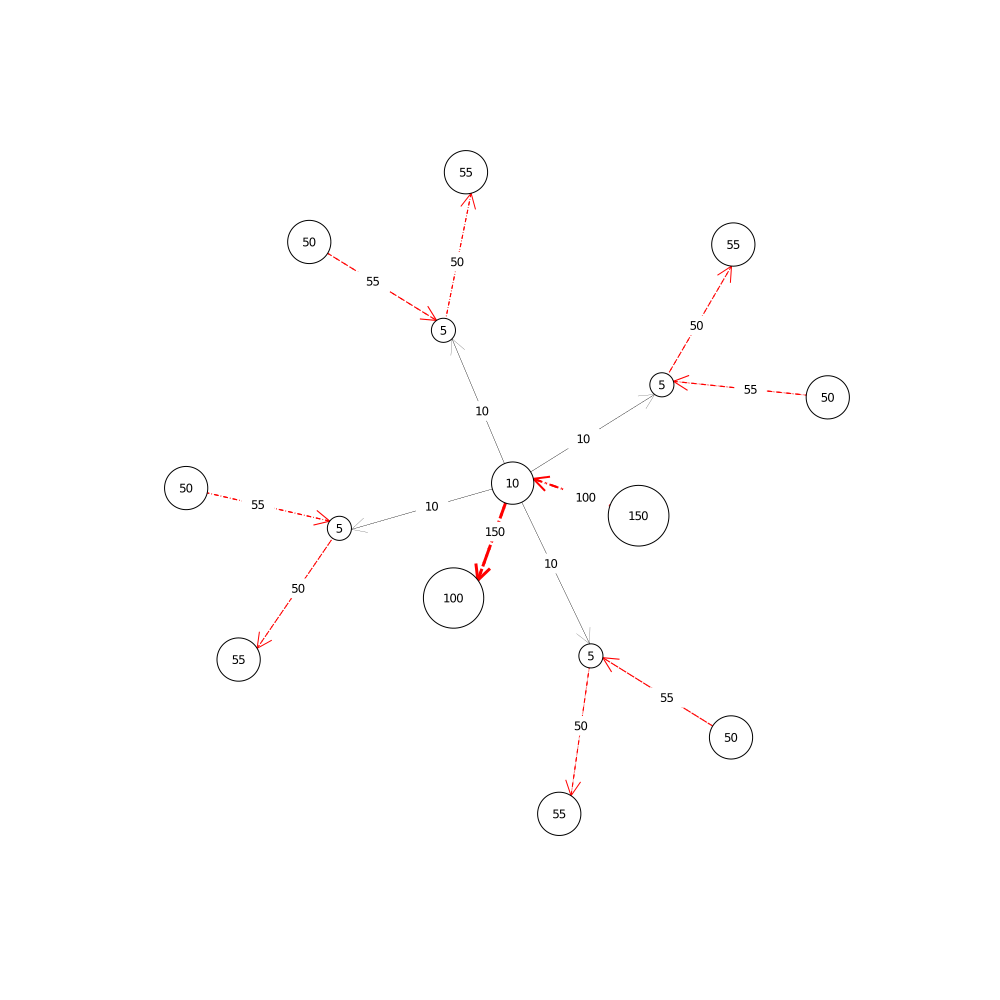

In [5]:
Aall = vcat(hcat(p_bar.*A,Diagonal([c...]),zeros(N,N)),hcat(vcat(zeros(N,N),Diagonal([b...])),zeros(2N,2N))); # relative liabilities matrix
Nall = size(Aall,1); # number of nodes

# plot it
graphplot(LightGraphs.DiGraph(Aall),
          nodeshape= :circle,
          markersize = 0.2,
          node_weights =  [hcat([w...],[b...],[c...]).^(1/30)...],
          markercolor = :white, #range(colorant"yellow", stop=colorant"red", length=N+1),
          names =  trunc.(Int,hcat(w...,b...,c...)),
          fontsize = 8,
          edgecolor = hcat(:red,:red,:black,:black,:black,:black,:red,:red,:red,:red,:red,:red,:red,:red),
          linestyle = hcat(:dashdot,:dashdot,:solid,:solid,:solid,:solid,:dashdot,:dashdot,:dashdot,:dashdot,:dashdot,:dashdot,:dashdot,:dashdot),
          edgewidth = (s,d,w)->0.02*Aall[s,d],
          arrow = true,
          method = :stress,
          curves = false,
          edgelabel = trunc.(Int,Aall),
          axis_buffer = 0.25,
          edgelabel_offset = 0,
          shorten = 0,
          edge_label_box = true,
          layout_kw = Dict(:iterations => 10000),
          size = (1000,1000),
)

We can also try different layouts by changing the keyowrd `method`; we will probably have to try different layouts when we plot bigger networks.

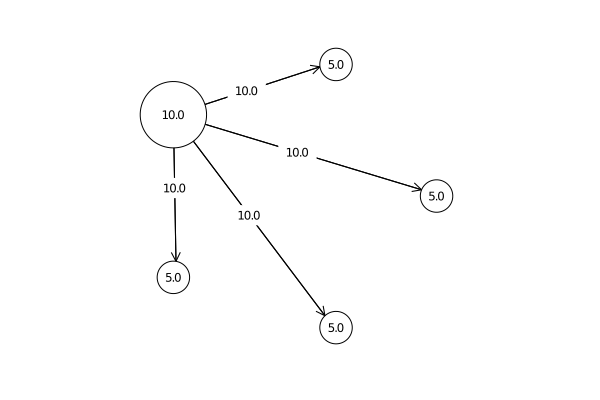

In [6]:
graphplot(LightGraphs.DiGraph(Aplot),
          nodeshape = :circle,
          markersize = 0.1,
          node_weights = w,
          markercolor = :white, #range(colorant"yellow", stop=colorant"red", length=N+1),
          names = w,
          fontsize = 8,
          linecolor = :darkgrey,
          edgewidth = (s,d,w)->15*Aplot[s,d], # width proportional to relative liabilities
          arrow = true,
          method = :circular,
          curves = false,
          edgelabel = p_bar.*A, 
    # attributes here: https://docs.juliaplots.org/latest/generated/graph_attributes/
    # method `:spectral`, `:sfdp`, `:circular`, `:shell`, `:stress`, `:spring`, `:tree`, `:buchheim`, `:arcdiagram` or `:chorddiagram`.
)

Shocks and Propagation
----------------------

The shocks we consider are exogenous reductions in the value of outside
assets. Therefore, all initial losses always originate outside the
network. One example of such a shock is an increase in defaults for
residential mortgages held by financial institutions.

For sufficiently high initial losses in outside assets, some nodes in
the network will be unable to pay their creditors in full. When this
happens, all debts for the defaulting node (including those outside the
network) are written down pro rata and creditors receive only a fraction
of their promised payments. Note that under a pro rata allocation, a
node defaults on either all of its creditors or none of them. When
creditors for some node are not paid in full, they may themselves be
unable to pay their own creditors, and so on. Initial losses thus get
transmitted inside the network through this “domino” effect. We do not
include in our analysis any liquidity or equity injections, and only net
claims between two nodes are assumed to be of relevance (as opposed to
gross positions). In addition, nodes do not renegotiate claims, even if
it may be mutually beneficial to do so.

As a numerical example, consider what happens when the outside assets of
the central node in <a href="#Fig1">Figure 1</a> receive a shock of size $80$. 
Outside assets for the central node
decrease from $150$ to $70$. Total liabilities are initially $140$.
After the shock, under a pro rata allocation, only $50$ percent of each
liability is repaid as the central node only has $70$ remaining in
assets. Each of the peripheral nodes receives $5$ from the central node,
just enough to balance their assets and liabilities. A shock to the
outside assets of the central node of magnitude greater than $80$ would
reduce the value of assets for peripheral nodes below the value of their
liabilities. In this case, the peripheral nodes would default on their
creditors. In this case, the central node has created contagion to the
peripheral nodes through network contagion. The peripheral nodes default
even though none of their outside assets were affected by the initial
shock.

<a href="#Fig2">Figure 2</a> shows a more complicated network in which a cycle of obligations of size $y$ runs through the peripheral nodes (the previous case we analyzed is obtained when $y=0$).

<figure>
    <img src='fig_networkExampleY.jpg' alt='Example of a more complicated network' id="Fig2" />
    <figcaption>Figure 2: A more complicated network</figcaption>
</figure>

To compute what happens after a shock $x=(x_1,x_2,...,x_N)$ to the outside 
assets of all nodes, 
it is necessary to first compute the *clearing vector*. The clearing vector
is an $N \times 1$ vector $p(x)$ such that

$$\begin{aligned}
p_{i}(x) =\min \left[ \bar{p}_{i},\max \left[ 0, \sum_{j=1}^{n}a_{ji}p_{j}\left( x\right) +c_{i}-x_{i}\right] \right] &\text{ for } i=1,..,N
\end{aligned}$$

or, in matrix notation,
$$\begin{equation*}
p(x) =\min \left[ \bar{p},\max \left[ 0,A^{T}p\left( x\right)
+c-x\right] \right] \label{eq:sys} \tag{1}
\end{equation*}$$

The above constitutes a system of $N$ non-linear equations in the $N$ variables $p_i(x)$. The system always has a solution, and the solution is unique. The reason is that the matrix
$A$ is substochastic (it has nonnegative entries with rows adding up to at most 1), and therefore has [spectral radius](https://en.wikipedia.org/wiki/Spectral_radius) less than 1. In turn, a spectral radius less than one makes the right-hand side of equation $\eqref{eq:sys}$ a contraction mapping -- existence and uniqueness follows from the [Banach fixed-point theorem](https://en.wikipedia.org/wiki/Banach_fixed-point_theorem). 

We interpret the clearing vector $p(x)$ as a mark-to-market valuation of all assets following a shock to the system. The initial value of node $i$’s liabilities, $\bar{p}_i$, is marked down to $p_i(x)$ as a consequence of the shock $x$, including through its impact on other nodes. This markdown reflects both the direct effect of the shock and the indirect effects of defaults spillovers.

Now let's solve the system of equations for the clearing vector $p(x)$ for any $y$ using Julia. We will start by looking at the simpler case with $y=0$ and then consider $y>0$.

In [7]:
# define the system of equations for the clearing vector p when the shock vector is x
function clearing_vec!(F, p, x)
    # when the system is solved, F is zero
    F .= p.-min.(p_bar,max.(A'*p .+c .- x,0))
end

# define the new network with cycle of liabilities y from Figure 2

# b, c and w are the same for any y (and the same as before)
b = (55.0, 55.0, 100.0, 55.0, 55); # outside liabilities
c = (50.0, 50.0, 150.0, 50.0, 50.0); # outside assets
w = (5.0, 5.0, 10.0, 5.0, 5.0); # net worth
N = length(c); # number of nodes

# first consider y=0
y = 0;
p_bar = (55.0+y, 55.0+y, 140.0, 55.0+y, 55.0+y); # total liabilities
A = [0 y/p_bar[1] 0 0 0; 0 0 0 y/p_bar[1] 0; 10.0/p_bar[3] 10.0/p_bar[3] 0 10.0/p_bar[3] 10.0/p_bar[3]; 0 0 0 0 y/p_bar[1]; y/p_bar[1] 0 0 0 0]; # matrix of relative liabilities
a = w .+ p_bar; # total assets
d = a .- c;# inside assets 
f = p_bar .- b;# inside liabilities

# shock to the central node of size 80
x = [0.0, 0.0, 80.0, 0.0, 0.0]
sol = nlsolve((F, p)->clearing_vec!(F, p, x),[p_bar...], autodiff = :forward) 
p = sol.zero; # the solution to the system

Before we move on, we do a unit test to make sure that `nlsolve` converges:

In [8]:
@test converged(sol)

Test Passed

Now we can compute all the new network quantities after the shock.

In [9]:
# network after the shock
# once we know p and x, we can compute all network quantities

p_bar_new = p # value of total liabilities after the shock
f_new = sum(A,dims=2).*p_bar_new # value of inside liabilities after the shock
b_new = p_bar_new .- f_new # value of outside liabilities after the shock

d_new = A'*p_bar_new #  value of inside asset safter the shock
c_new = c.-x # value of outside assets after the shock
a_new = d_new .+ c_new  # value of total assets after the shock

w_new = a_new .- p_bar_new; # value of equity after the shock

Let's interpret the results. 

But before that, a brief detour. Jupyterlab has three types of cell: raw, markdown, and code. I have not figured out how to reference a variable from a code cell (like `p` in the previous cell) so I can display its value while in a markdown cell. In Jupyter notebooks with IPython, one can do `{{p}}` to show the value of the variable `p`. But I have not found how to do this with Jupyterlab and IJulia. 

So for the next bit, instead of using a markdown cell, I will use a code cell with Julia markdown. As a side benefit, it will show some nice ways to use Julia markdown. Julia markdown is useful when creating documentation for packages.

In [10]:
## the next few lines format strings for Julia markdown

# convert some variables into nice latex equations to use inside Julia markdown
p_latex = latexify(string("p(x) = ", format.(p',precision=0)), env=:eq); # converts p to nice latex equation display using latexify, using format to choose number of decimals shown

# create a multi-line formula using align
p_bar_vec = [p_bar... ]; # convert tuple to vector to get square brackets (rather than parentheses) when converted to latex
p_loss = p_bar_vec .- p; # total losses = shock plus mark to market losses in liabilities

# round to integer to display without the decimals
p_str =  round.(Int64,p)
p_bar_str =  round.(Int64,p_bar_vec)
p_loss_str = round.(Int64,p_loss)
x_str = round.(Int64,x)
w_str = latexify(string("w = ", format.([w...]',precision=0)), env=:eq);
w_new_str = latexify(string("w = ", format.(w_new',precision=0)), env=:eq); 

# create each line of align environment
diff_latex_line1 = L" \bar{p}-p(x) =  %$(p_bar_str) - %$(p_str)" # L"..." defines a LaTeXString object, inside of which interpolation needs %$ instead of usual $
diff_latex_line2 = L" = %$(p_loss_str) "

# create align environment
diff_latex=latexify([diff_latex_line1,diff_latex_line2], env=:align) 
diff_latex=replace(diff_latex,"\$"=>"") # remove dollar sign from each line

## write nice output using Julia markdown
md"
The solution is contained in `p`, which in this case is $p_latex

Comparing $\bar{p}$ to $p(x)$, we get $diff_latex

which is the decline in value of total liabilities for each node. We see that only the 
central node had to mark down its liabilities.

On the other hand, they all experienced equity losses with initial (pre-shock) equity 
equal to $w_str and final (post-shock) equity equal to $w_new_str

So fact, they all lost all of their equity.

Now let's look at how things change when we have the cycle of liabilities
for the peripheral nodes, that is, when $y>0$. 
"

The solution is contained in `p`, which in this case is \begin{equation}
p\left( x \right) = \left[
\begin{array}{ccccc}
55 & 55 & 70 & 55 & 55 \\
\end{array}
\right]
\end{equation}


Comparing $\bar{p}$ to $p(x)$, we get \begin{align}
 \bar{p}-p(x) =&  [55, 55, 140, 55, 55] - [55, 55, 70, 55, 55] \\
 =& [0, 0, 70, 0, 0] 
\end{align}


which is the decline in value of total liabilities for each node. We see that only the  central node had to mark down its liabilities.

On the other hand, they all experienced equity losses with initial (pre-shock) equity  equal to \begin{equation}
w = \left[
\begin{array}{ccccc}
5 & 5 & 10 & 5 & 5 \\
\end{array}
\right]
\end{equation}
 and final (post-shock) equity equal to \begin{equation}
w = \left[
\begin{array}{ccccc}
0 & 0 & 0 & 0 & 0 \\
\end{array}
\right]
\end{equation}


So fact, they all lost all of their equity.

Now let's look at how things change when we have the cycle of liabilities for the peripheral nodes, that is, when $y>0$. 


In [11]:
# y>=0 and any shock vector x

# b, c and w are the same for any y (and the same as before)
b = (55.0, 55.0, 100.0, 55.0, 55); # outside liabilities
c = (50.0, 50.0, 150.0, 50.0, 50.0); # outside assets
w = (5.0, 5.0, 10.0, 5.0, 5.0); # net worth
N = length(c); # number of nodes

# compute clearing vector for cycle y and shock x
function clearing_vec_yx(y,x)
    p_bar = [55.0+y, 55.0+y, 140.0, 55.0+y, 55.0+y]; # total liabilities
    A = [0 y/p_bar[1] 0 0 0; 0 0 0 y/p_bar[1] 0; 10.0/p_bar[3] 10.0/p_bar[3] 0 10.0/p_bar[3] 10.0/p_bar[3]; 0 0 0 0 y/p_bar[1]; y/p_bar[1] 0 0 0 0]; # matrix of relative liabilities

    # need to re-define clearing_vec! because p_bar and A have been redefined locally inside clearing_vec_yx, while the original clearing_vec! uses the global values
    function clearing_vec2!(F, p, x)
        F .= p.-min.(p_bar,max.(A'*p .+c .- x,0))
    end
    
    sol = nlsolve((F, p)->clearing_vec2!(F, p, x),p_bar, autodiff = :forward)
    @test converged(sol)
    p = sol.zero
    return (p,p_bar)
end

# shock to the central node of size 80 with various values for y
x = [0.0, 0.0, 80.0, 0.0, 0.0]
y_grid = 0:100:1000
    
# initialize variables
p_grid = fill([], length(y_grid),1);p_bar_grid = fill([], length(y_grid),1)
i=1

# compute the clearing vector for each y
for y in y_grid 
    p_grid[i],p_bar_grid[i] = vcat(clearing_vec_yx(y,x))[1]
    i=i+1
end

## show results
headers = permutedims(["y", [string("clearing vec node ",i) for i=1:N]..., [string("liab markdown node ",i) for i=1:N]...]); # permutedims is like transpose but, unlike transpose (or adjoint), it works on an array of strings
numbers = [collect(y_grid) hcat(p_grid...)' hcat(p_bar_grid...)'.-hcat(p_grid...)'];

# using package Latexify
table = vcat(headers,numbers)
latexify(table,env=:mdtable, fmt = "%.0f", latex=false) |> display # show in screen -- note Jupyterlab does not support the latex tabular environment (because MathJax does not support it)
io = open("t2_table.tex", "w");print(io,latexify(table,env=:tabular, fmt = "%.0f", latex=false));close(io); # write to tex file using tabular environment

#=
# using package PrettyTables
pretty_table(numbers,headers,title="Liabilities for different y") # show in screen
t1 = pretty_table(String,[collect(y_grid) hcat(p_grid...)'],["y", [string("node",i) for i=1:N]...],title="Liabilities for different y",backend = :latex) # make into a latex table
io = open("t1_table.tex", "w");write(io, "$t1");close(io); # write to tex file
=#

|    y | clearing vec node 1 | clearing vec node 2 | clearing vec node 3 | clearing vec node 4 | clearing vec node 5 | liab markdown node 1 | liab markdown node 2 | liab markdown node 3 | liab markdown node 4 | liab markdown node 5 |
| ----:| -------------------:| -------------------:| -------------------:| -------------------:| -------------------:| --------------------:| --------------------:| --------------------:| --------------------:| --------------------:|
|    0 |                  55 |                  55 |                  70 |                  55 |                  55 |                    0 |                    0 |                   70 |                    0 |                    0 |
|  100 |                 155 |                 155 |                  70 |                 155 |                 155 |                    0 |                    0 |                   70 |                    0 |                    0 |
|  200 |                 255 |                 255 |                  70 |                 255 |                 255 |                    0 |                    0 |                   70 |                    0 |                    0 |
|  300 |                 355 |                 355 |                  70 |                 355 |                 355 |                    0 |                    0 |                   70 |                    0 |                    0 |
|  400 |                 455 |                 455 |                  70 |                 455 |                 455 |                    0 |                    0 |                   70 |                    0 |                    0 |
|  500 |                 555 |                 555 |                  70 |                 555 |                 555 |                    0 |                    0 |                   70 |                    0 |                    0 |
|  600 |                 655 |                 655 |                  70 |                 655 |                 655 |                    0 |                    0 |                   70 |                    0 |                    0 |
|  700 |                 755 |                 755 |                  70 |                 755 |                 755 |                    0 |                    0 |                   70 |                    0 |                    0 |
|  800 |                 855 |                 855 |                  70 |                 855 |                 855 |                    0 |                    0 |                   70 |                    0 |                    0 |
|  900 |                 955 |                 955 |                  70 |                 955 |                 955 |                    0 |                    0 |                   70 |                    0 |                    0 |
| 1000 |                1055 |                1055 |                  70 |                1055 |                1055 |                    0 |                    0 |                   70 |                    0 |                    0 |


We created a "more connected" network and the clearing vectors are indeed different depending on $y$. However, 
the markdown in liabilities ($\bar{p}-p$) are the same for all $y$. The reason 
is that the more connected nodes were the peripheral nodes, and these nodes did not default on their
obligations, so there was no default cascade arising from the cycle of liabilities $y$.

Let's try again, but now with a bigger shock to the central node.

In [12]:
# shock to the central node of size 94
x = [0.0, 0.0, 94.0, 0.0, 0.0]
y_grid = 0:100:1000
    
# initialize variables
p_grid = fill([], length(y_grid),1);p_bar_grid = fill([], length(y_grid),1)
i=1

# compute the clearing vector for each y
for y in y_grid 
    p_grid[i],p_bar_grid[i] = vcat(clearing_vec_yx(y,x))[1]
    i=i+1
end

## show results (just show markdown this time)
headers = permutedims(["y", [string("liab markdown node ",i) for i=1:N]...]); # permutedims is like transpose but, unlike transpose (or adjoint), it works on an array of strings
numbers = [collect(y_grid) hcat(p_bar_grid...)'.-hcat(p_grid...)'];

# using package Latexify
table = vcat(headers,numbers)
latexify(table,env=:mdtable, fmt = "%.0f", latex=false) |> display # show in screen -- note Jupyterlab does not support the latex tabular environment (because MathJax does not support it)
io = open("t2_table.tex", "w");print(io,latexify(table,env=:tabular, fmt = "%.0f", latex=false));close(io); # write to tex file using tabular environment


|    y | liab markdown node 1 | liab markdown node 2 | liab markdown node 3 | liab markdown node 4 | liab markdown node 5 |
| ----:| --------------------:| --------------------:| --------------------:| --------------------:| --------------------:|
|    0 |                    1 |                    1 |                   84 |                    1 |                    1 |
|  100 |                    3 |                    3 |                   84 |                    3 |                    3 |
|  200 |                    5 |                    5 |                   84 |                    5 |                    5 |
|  300 |                    6 |                    6 |                   84 |                    6 |                    6 |
|  400 |                    8 |                    8 |                   84 |                    8 |                    8 |
|  500 |                   10 |                   10 |                   84 |                   10 |                   10 |
|  600 |                   12 |                   12 |                   84 |                   12 |                   12 |
|  700 |                   14 |                   14 |                   84 |                   14 |                   14 |
|  800 |                   16 |                   16 |                   84 |                   16 |                   16 |
|  900 |                   17 |                   17 |                   84 |                   17 |                   17 |
| 1000 |                   19 |                   19 |                   84 |                   19 |                   19 |


Now we see that the markdown in liabilities is increasing in $y$ for the peripheral nodes. The markdown in liabilities for the central node, however,
is unaffected by $y$. This makes sense, since the peripheral nodes have no liabilities with respect
to the central node.

Let's plot the relation to see how fast total liabilities markdown (summed across all nodes)
grow with $y$.

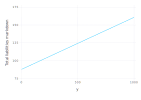

In [13]:
# plot using Gadfly package
p1=Gadfly.plot([numbers[:,1] sum(numbers[:,2:end],dims=2)],x=Col.value(1),y=Col.value(2),Geom.line,Guide.xlabel("y"),Guide.ylabel("Total liabilities markdown"))
draw(PGF("myplot.tex", 4inch, 3inch), p1) # save using PGF
draw(PNG("myplot.png", 4inch, 3inch), p1) # save to PNG
draw(PDF("myplot.pdf", 4inch, 3inch), p1) # save to PDF
display(p1)

Looks like the relationship is linear.

We can also solve the system by using the contraction mapping idea. Instead of 
solving the nonlinear system in equation (1) using `nlsolve`, we can think of the
right-hand side of (1) as a contraction mapping. Given an initial guess $p_0$ for
$p$, we apply the contraction mapping to $p_0$ to get $p_1$, and then we apply it
successively to get a sequence $p_0,p_1,p_2,...$ that converges to $p$

Why would we do this instead of using `nlsolve`? There are a few reasons:
- We know that if we pick $p_0=\bar{p}$, we will always converge to the solution. Other solution methods may not be as robust.
- The true solution for $p$ may be well approximated by two or three applications of the contraction map. Applying two or three iterations may be faster than solving the non-linear system.
- Automatic differentiation will always work when doing iterated applications of the contraction map, since AD can iterate over functions. Not sure it works if we use `nlsolve`; it should, but don't know if everything inside `nlsolve` is supported.

At the very least, we've learned that a good initial guess when using `nlsolve` is $\bar{p}$.

Let's now solve for $p$ using the contraction mapping idea and see how close each iteration is 
to the true solution.

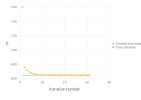

In [16]:
# re-define the network (with cycle of liabilities y as in Figure 2)
# to compute p, we only need p_bar, A and c

y = 100; # arbitrary y for illustration
p_bar = [55.0+y, 55.0+y, 140.0, 55.0+y, 55.0+y]; # total liabilities
A = [0 y/p_bar[1] 0 0 0; 0 0 0 y/p_bar[1] 0; 10.0/p_bar[3] 10.0/p_bar[3] 0 10.0/p_bar[3] 10.0/p_bar[3]; 0 0 0 0 y/p_bar[1]; y/p_bar[1] 0 0 0 0]; # matrix of relative liabilities
c = (50.0, 50.0, 150.0, 50.0, 50.0); # outside assets
N = length(c); # number of nodes

# solve for the clearing vector using nlsolve as before
x = [0.0, 0.0, 94.0, 0.0, 0.0] # shock to the central node of size 94
function clearing_vec!(F, p, x)
    F .= p.-min.(p_bar,max.(A'*p .+c .- x,0))
end
sol = nlsolve((F, p)->clearing_vec!(F, p, x),p_bar, autodiff = :forward) 
p_nlsolve= sol.zero; # the solution to the system
@test converged(sol)

# solve using contraction mapping idea

function contraction(p,x)
    # this is the contraction map
    min.(p_bar,max.(A'*p .+c .- x,0))
end
contraction_iter(x, n::Integer) = n <= 0 ? p_bar : contraction(contraction_iter(x,n-1),x) # applies contraction map n times

# compute result of applying contraction map a different number of times
n_grid = 0:30
p_iter = [sum(contraction_iter(x,n)) for n in n_grid];

# plot sum(p) vs number of iterations to see convergence
layer1=layer(p_iter,x=Col.index,y=Col.value,Geom.point,Theme(default_color=colorant"orange"))
layer2=layer(fill(sum(p_nlsolve),length(n_grid)),x=Col.index,y=Col.value,Geom.line)
p1=Gadfly.plot(layer1,layer2,Guide.xlabel("iteration number"),Guide.ylabel("p"), Guide.manual_color_key("",["Contraction map","True solution"],["orange","deepskyblue"]))

For this particular case, applying the contraction map 10 times essentially gets us to the solution.

We note that the fixed point of the contraction is a solution to the original system (1).

In [18]:
# compute fixed point of contraction and show it is equal to the solution of (1)
@test nlsolve(p-> p.-contraction(p,x),p_bar, autodiff = :forward).zero == p_nlsolve

Test Passed

Systemic Losses
---------------

To quantify network spillovers, we need to have a measure of the total systemic impact of a shock. We use the definition of systemic
losses in [Glasserman and Young (2015)](https://www.sciencedirect.com/science/article/pii/S0378426614000600#!), who state:

    There appears to be no commonly accepted measure of systemic impact in the prior literature. Eisenberg and Noe (2001) suggest that it is the number of waves of default that a given shock induces in the network. Other authors have suggested that the systemic impact should be measured by the aggregate loss of bank capital; see for example Cont et al. (2010). Still others have proposed the total loss in value of only those nodes external to the financial sector, i.e. firms and households.
    Here we shall take the systemic impact of a shock to be the total loss in [asset] value summed over all nodes, including nodes corresponding to financial entities as well as those representing firms and households. 

In terms of the variables of the network, the total loss in asset value summed over all nodes when a shock $x$ hits the network is

\begin{equation*}
    L(x) = \sum_{i=1}^{N} x_i + \bar{p}_i -p_i(x) \label{eq:sys} \tag{2}
\end{equation*}

The first term represents the direct loss, while the second term represents the indirect loss in value from reductions in payments by the nodes to other nodes and to the external sector.

The Disconnected Network
------------------------

To quantify the amplification of losses stemming from the network
structure –as opposed to the initial losses from exogenous shock to
outside assets– we compare expected losses for the system (the network
plus the outside sector) to the losses in a hypothetical system in which
all connections inside the network have been severed. Both networks are
subject to the same distribution of exogenous shocks to outside assets,
and to no other shocks. We create this hypothetical *disconnected*
system by removing all connections between nodes inside the original
network but keeping the links with the outside sector intact. We also
assume the net worth at each node remains unchanged by creating, for
each node, a fictitious claim to the outside sector equal in value to
the net value of all the connections that were removed. Depending on the
sign of the net value of removed connections, the new fictitious claim
can be an asset or a liability. If it is an asset, we assume it is not
subject to the shocks to outside assets to keep the set of assets
initially shocked identical to that of the original network. If the new
fictitious claim is a liability, we assume it has the same priority as
all other liabilities. In case of default, the new fictitious liability
gets haircut pro rata just like all other non-fictitious liabilities,
and any “losses” imposed on that obligation are counted towards the
value of total system losses. Figure
<a href="#Fig3">Figure 3</a>
shows the disconnected version of network displayed in Figure
<a href="#Fig1">Figure 1</a>.

<figure>
    <img src='../../paper/fig2_networkDisconnected.png' alt='A disconnected network' id="Fig3" />
    <figcaption>Figure 3: A disconnected network</figcaption>
</figure>

To plot the disconnected network, we create the fictitious assets and liabilities and use a relative liabilities matrix $A$ with 
all entries equal to zero.|

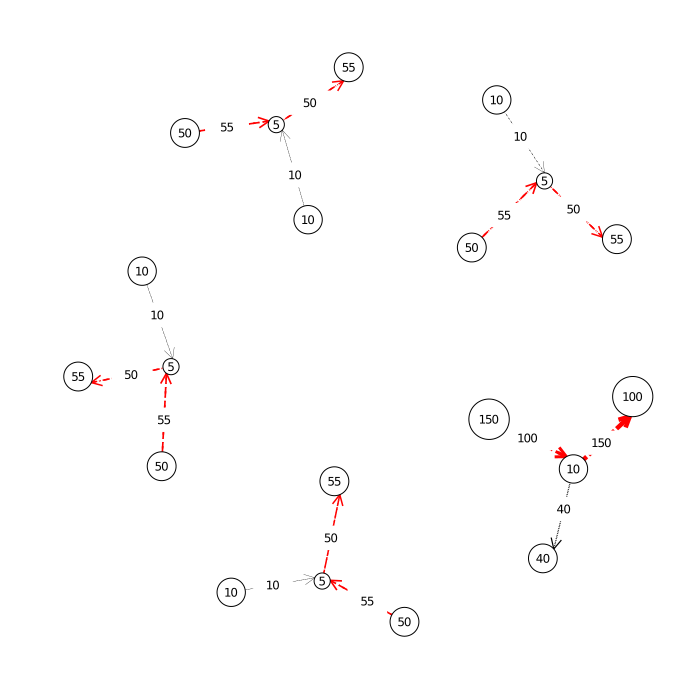

In [265]:
# plot the disconnected network from Figure 3

b_fict = max.(0,f.-d); # fictitious outside liabilities
c_fict = max.(0,d.-f); # fictitious outside assets

Adis_pre1 = vcat(hcat(zeros(size(A)),Diagonal([c...]),zeros(N,N)),hcat(vcat(zeros(N,N),Diagonal([b...])),zeros(2N,2N))); # relative liabilities matrix including outside sector
Adis_pre2 = hcat(vcat(Adis_pre1,hcat(vcat(zeros(N,N),Diagonal([c_fict...])),zeros(2N,size(Adis_pre1,2)-N))),hcat(vcat(Diagonal([b_fict...]),zeros(size(Adis_pre1,1)+N,size(b_fict,1))),zeros(size(Adis_pre1,1)+2N,size(c_fict,1)))) # add fictitious nodes

# remove fictitious nodes with zero assets or zero liabilities
keep1 = sum(Adis_pre2,dims=1).+sum(Adis_pre2,dims=2)'  # sum of assets and liabilities for each node
keep2 = findall(x->x != 0,keep1); # index equal to 1 if sum of assets and liabilities is not zero
keep3 = last.(Tuple.(keep2)); # convert to use in Adis

# remove nodes
Adis = Adis_pre2[keep3,keep3] 
b_fict = filter(x->x!=0,b_fict)
c_fict = filter(x->x!=0,c_fict)
Nall = size(Adis,1) # number of nodes

# plot it
graphplot(LightGraphs.DiGraph(Adis),
          nodeshape=:circle,
          markersize = 0.12,
          node_weights = [vcat([w...],[b...],[c...],[b_fict...],[c_fict...])...].^(1/30),
          markercolor = :white, #range(colorant"yellow", stop=colorant"red", length=N+1),
          names =  trunc.(Int,hcat(w...,b...,c...,b_fict...,c_fict...)),
          fontsize = 8,
          edgecolor = hcat(:red,:red,:red,:black,:red,:red,:red,:red,:red,:red,:red,:black,:black,:black,:black),
          linestyle = hcat(:dashdot,:dashdot,:dashdot,:dot,:dashdot,:dashdot,:dashdot,:dashdot,:dashdot,:dashdot,:dashdot,:dashdot,:dashdot,:dashdot,:dashdot,:dashdot,:dot,:dot,:dot,:dot),
          edgewidth = (s,d,w)->0.03*Adis[s,d],
          arrow=true,
          method= :stress,
          curves=false,
          edgelabel= trunc.(Int,Adis),
          axis_buffer=0.1,
          edgelabel_offset=0,
          shorten=0,
          edge_label_box=true,
          layout_kw= Dict(:iterations => 10000),
          size=(700,700)
    # attributes here: https://docs.juliaplots.org/latest/generated/graph_attributes/
    # method `:spectral`, `:sfdp`, `:circular`, `:shell`, `:stress`, `:spring`, `:tree`, `:buchheim`, `:arcdiagram` or `:chorddiagram`.
          )

An Upper Bound on Network Spillovers
------------------------------------

We are interested in whether the expected system losses in our
real-world, interconnected system, are substantially greater than those
in the hypothetical *disconnected* system, where node connections have
been excised. We define $R$ to be the ratio of expected losses for the
actual network to the expected losses in the disconnected network. That
is, if $L(x)$ denotes total system losses defined as in Equation 2,

$$R=\frac{E(L_{\text{Actual}}(x))}{E(L_\text{Disconnected}(x))}$$

where the expectation is computed with respect to the distribution of
the shock $x$. The value of $R$ gives the relative magnitude of additional losses
imposed on the system because of the interconnected structure of the
network - to wit, network effect losses. With perfect information on the
bilateral claims in the system, this ratio could be calculated exactly
in response to a variety of shocks by using the algorithm to compute the
set of node payments that clear the system (i.e. follow the system’s
rules of limited liability and pro rata allocation). In the United
States' financial system, detailed and publicly-available data on
bilateral obligations between financial firms does not exist.

The main result in [Glasserman and Young (2015)](https://www.sciencedirect.com/science/article/pii/S0378426614000600#!) is that a useful upper-bound on $R$ can be derived
without any information regarding each node’s bilateral claims together with two 
mild assumptions regarding the shocks.
We call this upper-bound $B$. The first assumption regarding the shocks is on their
distribution. The distribution cannot be too fat-tailed.[<sup>3</sup>](#fn3).The second
assumption is that the shocks are "homogeneous" with respect to $c$: If $F(x_1,x_2,...,x_N)$ is
the cdf of $x=(x_1,x_2,...,x_N)$, then we can write 
$F(x_1,x_2,...,x_N)=G(x_1/c_1,x_2/c_2,...,x_N/c_N)$ for some symmetric cdf G. When these two assumptions hold, $B$ can be calculated using node-specific information only.

In practice, we deal with the homogeneity assumption by writing $x_i = \tilde{x}_i c_i$ for some shock 
$\tilde{x}_i \in [0,1]$ whose cdf is not restricted to be homogeneous (with slight abuse
of notation, we use $x$ for both $x$ and $\tilde{x}_i$).

More specifically, [Glasserman and Young (2015)](https://www.sciencedirect.com/science/article/pii/S0378426614000600#!) show that $B$
depends only on each node’s total outside assets $c$, each firm’s
probability of default due to direct shocks to outside assets $\delta$,
and the maximum *liability connectivity* among nodes in the system
$\beta^+$. Each node’s liability connectivity is defined as its ratio of
inside liabilities to total liabilities. The formula for $B$ is

$$\label{eq:B}
B=1+\frac{1}{(1-\beta ^{+})}\frac{\sum_{i \in S} {\delta _{i}c_{i}}}{\sum_{i \in S}{c_{i}}},$$

where 

$$\begin{aligned}
\delta_{i} &:\text{probability of default from outside shocks for node }i, \\
c_{i} &:\text{the dollar value of outside assets for node }i, \\
\beta ^{+} &:\text{maximum liability connectivity, i.e., }\beta^{+}=\max_{i \in S}\beta _{i}\text{, with } \beta_i=\text{the fraction of } \\
& \text{firm i's liabilities held by other nodes in the networks}, \\
S &:\text{Set of financial institution nodes within the network.}\end{aligned}$$

The upper bound $B$ for network spillovers is increasing in the maximum
financial connectivity of the system, $\beta ^{+}$, and in the quantity
$\sum {\delta _{i}c_{i}}/\sum {c_{i}}$, most-easily interpretable as a
weighted average probability of default for the system (with each firm’s
weight given by its share of total outside assets). When $\beta ^{+}$ is
close to $1$, aggregate financial connectivity is high and any initial
shock to outside assets has the potential to be transmitted broadly
across the network. In contrast, when $\beta ^{+}$ is close to zero, any
initial shock dissipates quickly and expected losses should be similar
to those in a truly disconnected network.

For most systems calibrated to real-world data, previous studies have
found that the upper bound $B$ is small. For example, picking
$\beta ^{+}=0.8$ and $\delta _{i}=1$ percent for all nodes $i$, we get
$B=1+0.01/(1-0.8)=1.05$. This means that the connected system has
expected losses that are at most $5$ percent larger than those in the
system of isolated nodes. [Glasserman and Young (2015)](https://www.sciencedirect.com/science/article/pii/S0378426614000600#!) 
provide an example for European banks using data from the
the 2011 European Banking Authority stress test. They find 
an even smaller upper bound of $1.0175$. If the *upper bound*
is low, then the actual ratio $R$ is also low, with the implication
that network default spillovers for financial institutions is not, by itself,
a big source of amplification of shocks.

Unlike these examples, when we use data for the US, we find that the bound 
$B$ can be large in certain periods, especially around the 2008 financial crisis. 
Figure 4 shows the empirical estimate we have for $B-1$. We see that the
bound exceeds ten percent for a number of years and can reach almost forty percent
at its peak.

<figure>
    <img src='../../output/NVI_benchmark.png' alt='Example of a network' id="Fig4" />
    <figcaption>Figure 4: Estimated upper bound $B$ using all US financial firms </figcaption>
</figure>

Now, a large bound $B$ still leaves unresolved the issue of how large $R$ is. We had discussed
that a low upper bound necessarily means spillovers are small. But what can we say if the 
upper bound is large? The actual ratio $R$ can be anywhere between zero and $B$.

Our main goal
--------------

Our main goal is to estimate the range of values for $R$ that are consistent 
with our empirical (node-specific) data. If the range is not too wide and close to
$B$, then we have a stronger case for spillovers being large. If the range is not too
wide but close to zero, then we have evidence against spillovers being large. Last,
the range can be wide, in which case we do not have a lot of additional information.

The empirical data that we observe are the values of $w_i, c_i, assets_i, \bar{p}_i, b_i, \delta_i$ for a subset of nodes. The subset of nodes for which we observe $w_i$ is not the same
as the subset for which we observe $c_i$, and the same for all other variables. So for
example, we may have all of $w_1, c_1, assets_1, \bar{p}_1, b_1, \delta_1$ for firm $i=1$, only $w_2, c_2, \delta_2$ for firm $i=2$, and only $assets_i$  for $i=3$. 

Conceptually, what we want to do is to look at all possible networks whose values for
$w_i, c_i, assets_i, \bar{p}_i, b_i, \delta_i$ match those from the data. Then we compute the highest and lowest $R$ across all of these networks.

Of course, we cannot look at all possible networks. We do not observe $A$, which is $N \times N$, and looking over $N^2$ values is just not feasible (ok, it is not exactly $N^2$ because there are some restrictions, like the diagonal has to be all zeros, but the restrictions are not enough to bring the number down enough). So instead of really looking at all possible networks, we think of the task as a maximization or minimization problem, where we maximize or minimize $R$ subject to the constraints that observed data is respected and network relations hold (for example, a "network relation" is that outside assets cannot be larger than total assets).

Bankruptcy costs
----------------



Optimization
-------------

Let's be more precise. The optimization problem is the following.

Choose $p_{i}(x), \bar{p}_{i}, c_{i}, \text{assets}_{i}, b_{i}, d_{i}, f_{i}, \delta_i$ for $i=1,...,N$, $a_{ij}$ for $i,j=1,...,N$, and a cumulative distribution function $G(x_1,x_2,...,x_N)$ where $x_i \in [0,1]$ for $i=1,2,...,N$, in order to maximize\minimize

$$\begin{equation}
\mathbb{E}\left[ \sum_{i=1}^{N}\left( c_{i}x_{i}+\bar{p}_i-p_{i}\left( x\right) \right) %
\right] 
\end{equation}$$

subject to the following constraints:

1. Box constraints (sometimes also called "bound" constraints)
$$\begin{aligned}
0 &\leq p_{i} \leq \bar{p}_{i} & \text{,} &\text{ for }i=1,..,N \\
0 &\leq c_{i} \leq assets_{i} & \text{,} &\text{ for }i=1,..,N \\
0 &\leq b_{i} \leq \bar{p}_{i} & \text{,} &\text{ for }i=1,..,N \\
0 &\leq a_{ij} \leq 1 & \text{,} & \text{ for }i,j=1,..,N.
\end{aligned}$$

2. Linear constraints
$$\begin{aligned}
\sum_{j=1}^{n}a_{ji}\bar{p}_{j} &=d_{j}\text{,} &\text{ for }i=1,..,N \\
\bar{p}_{i}\sum_{j=1}^{n}a_{ij} &=f_{i}\text{,} &\text{ for }i=1,..,N \\
\end{aligned}$$

3. Complementarity constraints (sometimes also called "equilibrium" constraints)
$$\begin{aligned}
a_{ii} &=0\text{,} &\text{ for }i=1,..,N \\
a_{ij}a_{ji} &=0 \text{,} &\text{ for }i=1,..,N\text{ and }j<i.
\end{aligned}$$

4. Non-linear constraints
$$\begin{aligned}
p_{i}(x) =\min \left[ \bar{p}_{i},\max \left[ 0, \sum_{j=1}^{n}a_{ji}p_{j}(x) +c_{i}-c_{i}x_{i}\right] \right] &\text{ for } i=1,..,N
\end{aligned}$$

5. Probabilistic constraints
$$\begin{aligned}
\delta_i = Pr(c_i x_i\geq w_i) &\text{ for } i=1,..,N
\end{aligned}$$
where $x_i \in [0,1]$ has cdf $G(x_1,x_2,...,x_N)$.

Some comments on this optimization problem:

1. We would love to solve this problem for $N=150$, which is the approximate number of nodes in the data. However, I would be very happy if we can solve this using the largest $N=50$ nodes. At a minimum, we need $N=25$.

2. Computing the expectation in the objective function is the hardest part of the problem in terms of the raw amount of computation. We can always write the expectation as an $N$-dimensional integral. If we wanted to break the domain $[0,1]^N$ into small hypercubes to approximate the integral with sums, and we approximate the interval $[0,1]$ with a grid of ten points, we would need $10^N$ hypercubes. Even for $N=10$, we get too big a space. The most common method to compute multi-dimensional integrals is by using Monte Carlo simulations. But there are other ideas out there as well.

3. Complementarity constraints are easy to understand/visualize: in the $N \times N$ matrix $A$, if some $a_{ij}$ element is non-zero, then the element that is symmetric with respect to the diagonal, $a_{ji}$, has to be zero. So $A$ has at least half of its non-diagonal elements equal to zero (and the diagonal elements all equal to zeros). However, they introduce some problems. First, there is a combinatorial aspect to them. We can imagine first picking which elements are non-zero below the main diagonal. The choice imposes some zeros above the diagonal. Once we know which elements must be zero, we optimize over all the other ones ignoring the complementarity constraints. But there are many, many ways to pick the non-zero elements in the first place! Second, most "normal" solvers, especially those that rely heavily on everything being smooth, have a very difficult time solving these complementarity constraints without any special treatment. Their derivatives blow up close to zero, and solutions are always at a corner for at least half the variables. Third, they are the only constraints that destroy the "convexity" of the problem. Without these constraints, we could re-write the problem so that the objective is convex and the constraint set is also convex, which are much much easier and faster to solve numerically.

4. The choice of the cdf G means that our problem is infinite dimensional: we have to choose an entire function, not just a finite set of numbers. If we knew G, then the problem is finite-dimensional.

5. Probabilistic constraints can be tricky for automatic differentiation. If we are doing a Monte Carlo to compute the expectation in the objective function, we need to draw from G. But we are also optimizing over G. This has two implications. First, every time we change G, we need to change the distribution we use for Monte Carlo. Second, it may be tricky to compute the "derivative" of the objective function with respect to G. For each small deviation from the current G, it seems like we would need to do an entire new Monte Carlo run to find how the objective changes.

The following [slides](NetworkContagion_presentation.pdf) work out an example in which the initial shock to the 
outside assets of the central node is $94$.

Footnotes
---------

[1] <span id="fn1">More technically, we consider shocks that have an “increasing
failure rate" (IFR). A random variable with distribution function
$G\left( x\right)$ and density $g\left( x\right)$ is said to have an IFR
if $g\left( x\right) /(1-G\left( x)\right)$ is an increasing function of
$x$ . This family encompasses the normal, exponential, and uniform
distributions. There are no restrictions on the correlation structure of
shocks.

In addition, the joint distribution of potential shocks is assumed to be
invariant to scale (homogeneous in assets). For example, if total assets
of a node double, expected losses are assumed to also double.</span>

[2] <span id="fn2">In this section, we have used the words “small” and “large” to
characterize different levels of the $NVI$ without being explicit about
their meaning. This was a deliberate choice, since the model provides no
welfare analysis and no other indication on how to evaluate the overall
magnitude of the $NVI$. In short, the burden of interpreting what
constitutes small or large values for the $NVI$ is the policymaker’s.</span>

[3] <span id="fn3">The bounds derived by are actually stronger than this - applying to
the probability of node $i$ causing default through contagion to a given
*group* of firms.</span>